# Tải thư viện 

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats
from tqdm import tqdm

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats

# Tiền xử lí dữ liệu
**Vấn đề**
- Dữ liệu ban đầu sẽ có thể có nhiễu, bị khuyết, chưa rõ đặc tính và đặc trưng  

**Công việc**
- Kiểm tra dữ liệu bị khuyết, loại bỏ nhiễu.
- Phân tích đặc trưng của tập dữ liệu: Kích thước, phân bố, mối quan hệ giữa hai trường dữ liệu  

**Kết quả dự kiến**
- Đặc điểm của dữ liệu  
- Dữ liệu sạch: Không có nhiễu, bị khuyết 
- Tập đặc trưng được trích chọn và được chuẩn hóa  

**Bình luận**
- Pha tiền xử lí nhằm:
    - Khử nhiễu, loại bỏ dữ liệu bị khuyết  
    - Phân tính đăc điểm của dữ liệu phục vụ cho việc trích chọn đăng trưng, sử dụng các chiến thuật hợp lí sau này  
    - Trích chọn đặc trưng của dữ liệu  
    - Chuẩn hóa các đặc trưng nafy

## Phân tích đặc điểm dữ liệu 

### Tập huấn luyện 

In [3]:
Path('data/train.csv').stat().st_size

9555558244

**Vấn đề**: Cần biết kích thước dữ liệu để đọc dữ liệu phù hợp. Vì nếu dữ liệu quá lớn thì không thể đọc hết cùng một lúc.  
**Công việc:** In ra độ lớn của tập huấn luyện   
**Kết quả dự kiến:** Độ lớn của tập huấn luyện   
**Bình luận:** Đối với em, đây là một bộ dữ liệu lớn gây ra rất nhiều khó khăn. Em đã tìm hiểu khác nhau để tải và xử dụng dữ liệu:
- **Cách 1: Dùng google colab để móc dữ liệu về qua Kaggle API:**
        - Ưu điểm: Tốc độ Download nhanh. Xử dụng được colab với sự hỗ trợ của GPU.
        - Nhược điểm: Dữ liệu lưu tạm thời trên máy ảo. Mỗi lần tải lại lại mất.
- **Cách 2: Dùng jupyter notebook ở local:**
        - Ưu điểm: Có thể train khi không có mạng. Không phải tải lại bộ dữ liệu.
        - Nhược điểm: Không có GPU. Không thể đọc một lúc toàn bộ file train 
Sau quá trình cân nhắc, em đã lựa chọn ***cách 2***. Em khắc phục nhược điểm bằng cách khi visualization chỉ sử dụng một phần tập train. Khi trích chọn đặc trưng thì dùng cửa sổ trượt để đọc từng segment một. 

**Vấn đề:** Cần biết đặc điểm của dữ liệu để xử lí phù hợp  
**Công việc:** Dùng hàm `infor` và hàm `describe` 

In [5]:
train = pd.read_csv('data/train.csv', nrows=6000000)
train.info()
print("==================")
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 2 columns):
 #   Column           Dtype  
---  ------           -----  
 0   acoustic_data    int64  
 1   time_to_failure  float64
dtypes: float64(1), int64(1)
memory usage: 91.6 MB
       acoustic_data  time_to_failure
count   6.000000e+06     6.000000e+06
mean    4.545660e+00     1.350958e+00
std     2.277303e+01     2.533610e+00
min    -4.621000e+03     7.954798e-04
25%     2.000000e+00     3.902964e-01
50%     5.000000e+00     7.796974e-01
75%     7.000000e+00     1.169098e+00
max     3.252000e+03     1.154080e+01


**Kết quả:**: Hai bảng mô tả về dữ liệu  
**Bình luận:** Dữ liệu **acoustic_data** có trường int64 lớn có thể hạ xuống int16 để giảm bộ nhớ. **time_to_failure** cũng có trường float64, tuy nhiên thời gian cần được biểu diễn chính xác nên không hạ xuống trường thấp hơn.

Trường acoustic_data được đọc lại với dữ liệu acoustic_data chuyển xuống int16 với mục đích trình bày ở bình luận trên 

In [15]:
train = pd.read_csv('data/train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 
                                                                                 'time_to_ failure': np.float64})

**Vấn đề:** Dữ liệu null ảnh hướng lớn tới các mô hình học, có thể gây ra lỗi  
**Công việc:** Kiểm tra null

In [16]:
#check null
print(train.acoustic_data.isnull().values.any())
print(train.time_to_failure.isnull().values.any())

False
False


**Kết quả:** Dữ liệu có null hay không  
**Bình luận:** Dữ liệu không có null 

**Vấn đề:** Cần biết phân bố dữ liệu để nhìn ra một số đặc trưng cần thiết  
**Công việc:** Tiến hành lấy mẫu 600000 dữ liệu và vẽ biểu đồ sự phân bố

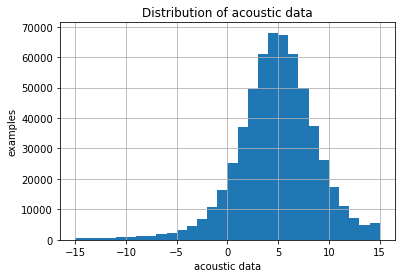

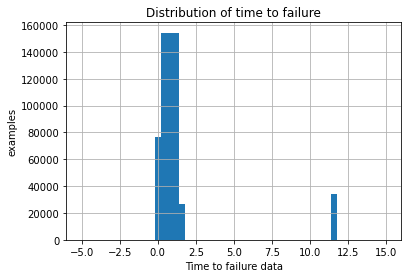

In [8]:
#Version 1
#Acoustic data distribution
# train_sample = train.sample(frac=0.1) 
# plt.figure(figsize=(10,5)) 
# plt.title("Acoustic data distribution") 
# ax = sns.distplot(train_sample.acoustic_data)

#Version 2
train_sample = train.sample(frac=0.1)
train_sample['acoustic_data'].hist(bins=30, range = [-15,15], align='mid')
plt.title("Distribution of acoustic data")
plt.xlabel('acoustic data')
plt.ylabel('examples')
plt.show()

#Version 1
# plt.figure(figsize=(10,5)) 
# plt.title("Time to failure distribution") 
# ax = sns.kdeplot(train_sample.time_to_failure)

#Version 2
train_sample['time_to_failure'].hist(bins=50, range = [-5,15], align='mid')
plt.title("Distribution of time to failure")
plt.xlabel('Time to failure data')
plt.ylabel('examples')
plt.show()
del train_sample

**Kết quả:** 
- Phân bố của tín hiểu trong khoảng [-15,15]
- Phân bố của time_to_failure nằm trong khoảng [0, 12]. Trong đó tập trung trong khoảng từ [0,2]

**Bình luận:**
- Với dữ liệu time_to_failure có thể đẩy các dữ liệu dự đoán về hai khoảng phổ biến này nhằm tăng độc chính xasc

**Vấn đề:** Mối quan hệ của hai thuộc tính có thể cung cấp một cái giải pháp nào đó  
**Công việc:** Vẽ biểu đồ biểu diễn các cặp giá trị (acoustic, time)

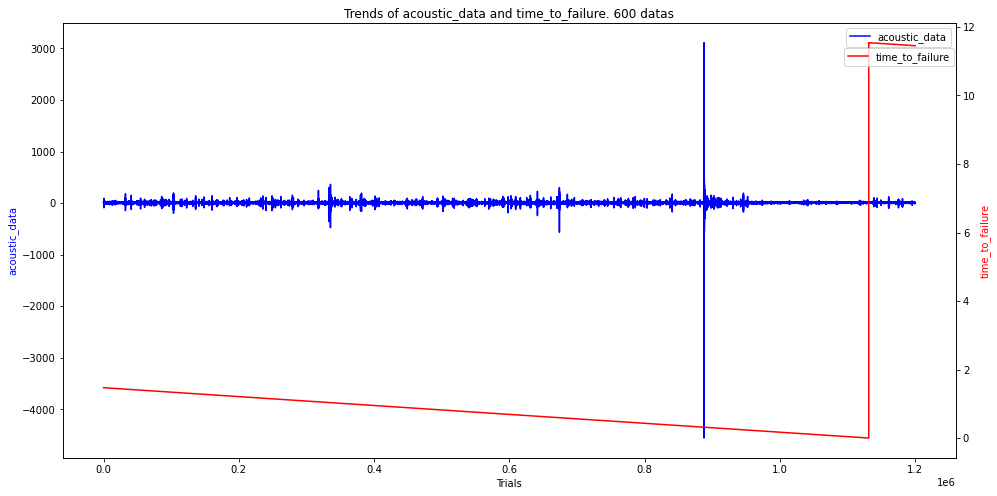

In [9]:
#Lấy 6000000/5 = 1200000 mẫu dữ liệu 
train_acoustic_data_small = train['acoustic_data'].values[::5]
train_time_to_failure_small = train['time_to_failure'].values[::5]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 600 datas")

#Vẽ acoustic data
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
ax1.set_xlabel('Trials')
plt.legend(['acoustic_data'])

#Vẽ time_to_failure data
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='r')
ax2.set_ylabel('time_to_failure', color='r')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))

#Giải phóng
del train_acoustic_data_small
del train_time_to_failure_small

**Bình luận**
- Chúng ta có thể thấy rằng thông thường dữ liệu tín hiệu cho thấy những biến động lớn ngay trước khi xảy ra động đất và bản chất của dữ liệu là theo chu kỳ.
- Một điểm quan trọng khác: các lỗi bằng mắt thường có thể được dự đoán là các trường hợp khi các biến động lớn của tín hiệu được theo sau bởi các giá trị tín hiệu nhỏ cần tìm cách xử lí.
- Tín hiệu có dạng âm thanh, có thể tiến hành xử lí trong một số trường dữ liệu khác như là như là FFT. 



### Tập kiểm tra

**Vấn đề:** Kiểm tra các đặc điểm của tập test tương ứng   
**Công việc:** In ra các đặc điểm của 3 tập test ngẫu nhiên  

In [14]:
test1 = pd.read_csv('data/test/seg_00030f.csv') 
test2 = pd.read_csv('data/test/seg_1dec9c.csv') 
test3 = pd.read_csv('data/test/seg_5cfba9.csv') 

print("Information about test 1")
test1.info()
print('\n')

print("Information about test 2")
test2.info()
print('\n')

print("Information about test 3")
test3.info()
print('\n')

Information about test 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   acoustic_data  150000 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB


Information about test 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   acoustic_data  150000 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB


Information about test 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   acoustic_data  150000 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB




**Kết quả:** Đặc điểm của từng tập dữ liệu test  
**Bình luận:** Các tập dữ liệu test đều không có trường null

Visualize sự phân bố của acoustic data trong khỏang [-15,15]

**Vấn đề:** Nếu sự phân bố của dữ liệu test khác so với tập dữ liệu huấn luyện thì sẽ khó dữ đoán hơn
**Công việc:** Vẽ biểu đồ sự phân bố của của ba tập test trên 

Text(0.5, 1.0, 'Distribution of acoustic data in test 1')

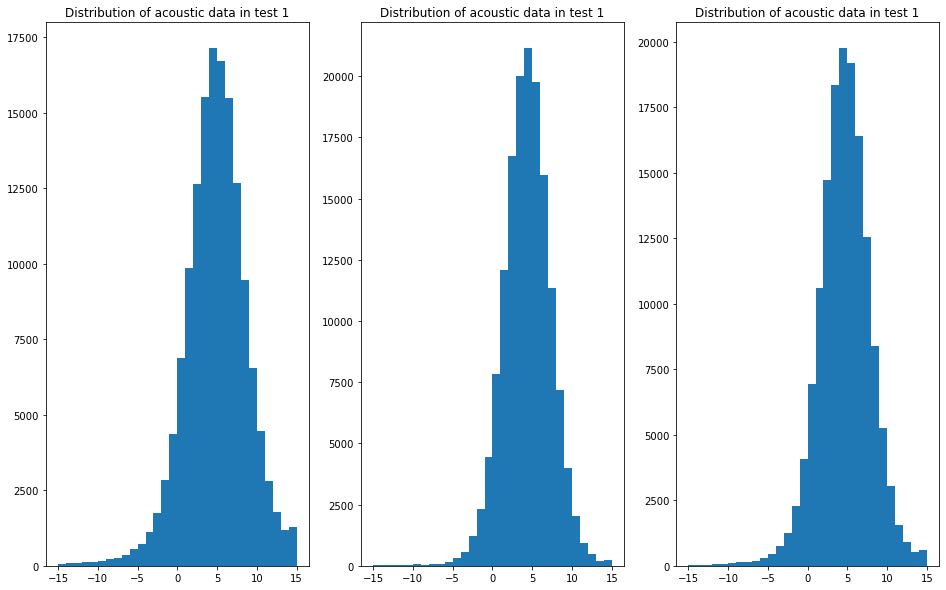

In [18]:
f, axarr = plt.subplots(1, 3,figsize=(16,10))

axarr[0].hist(test1.acoustic_data, bins=30, range = [-15,15], align='mid')
axarr[0].set_title("Distribution of acoustic data in test 1")

axarr[1].hist(test2.acoustic_data, bins=30, range = [-15,15], align='mid')
axarr[1].set_title("Distribution of acoustic data in test 1")

axarr[2].hist(test3.acoustic_data, bins=30, range = [-15,15], align='mid')
axarr[2].set_title("Distribution of acoustic data in test 1")

**Kết quả:** Biểu đồ biểu diễn dữ liệu của ba tập test được biểu diễn   
**Bình luận:** Ta có thể thấy sự phân bố của acoustic data trong test tương đối giống với tập train 

## Trích chọn đặc trưng 

Dưới đây là hai hàm trích chọn đăng trưng em không dùng thư viện. Công dụng sẽ được em giải thích chi tiết phía dưới:

In [19]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

In [20]:
#Chênh lệch trung bình giữa các giá trị liên tiếp về giá trị phần trăm;
def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

**Vấn đề:** Để huấn luyện mô hình học máy cần trích chọn các đặc trưng cần thiết.  
**Công việc:** Trích chọn một số đặc trưng để phục vụ cho mô hình học máy
Mỗi dòng trong file test có 150000 cột tín hiệu. Vì vậy,em dùng hàm for để đọc, mỗi lần đọc lấy ra 150000 dữ liệu từ tập train rồi tiến hành trích chọn đăng trưng ngay sau đó.
Có hai hướng trích chọn đăc trưng:
- Lấy nguyên dữ liệu **raw** để sử dụng cho mô hình deep learning.
- Trích chọn các feature để đưa vào các mô hình học máy. 

Một số feature được lưa chọn để đưa vào mô hình học máy:
- Trong trường biểu diễn ban đầu 
    - Một số tổng hợp thông thường: mean, std, min, max  
    - Chênh lệch trung bình giữa các giá trị liên tiếp về giá trị tuyệt đối và giá trị phần trăm;   
    - Tổng hợp nói trên cho các giá trị 10000 và 50000 đầu tiên và cuối cùng 
    - Thương, hiệu giữa đồ lớn max và abs(min), đếm các khoảng cách max và min > một ngưỡng.  
    - Tính toán Quantile
    - Trend features   
    - Rolling features tisnht toán các chỉ số bằng cách dùng cửa sổ cuoojn

Quantile: q-th quantile tính toán lượng tử thứ q ở phân bố mô tả sự phân bố và sự phân tán của tập dữ liệu trong từng phần. 
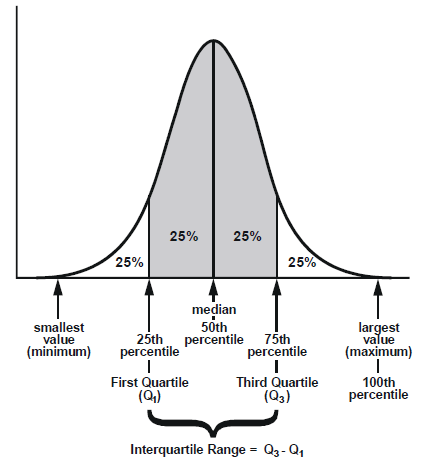

In [73]:
x = pd.Series(train['acoustic_data'].values)
change = (np.diff(x) / x[:-1]).values

In [99]:
rows = 150000
parts = int(60000000/rows)

X= pd.DataFrame(index=range(parts), dtype=np.float64)
Y= pd.DataFrame(index=range(parts), dtype=np.float64,columns=['time_to_failure']) 

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_sum = np.abs(train['acoustic_data']).sum()

for segment in tqdm(range(parts)): 
    data = pd.read_csv('data/train.csv', nrows = rows, skiprows=segment*rows+1)
    x = data.iloc[:,[0]].values
    x = pd.Series(x.reshape(len(x),))
    y = data.iloc[:,[1]].values[-1]
    
    Y.loc[segment, 'time_to_failure'] = y
    
    #Một số tổng hợp thông thường: mean, std, min, max
    X.loc[segment, 'mean'] = x.mean()
    X.loc[segment, 'std'] = x.std()
    X.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X.loc[segment, 'abs_std'] = np.abs(x).std()
    X.loc[segment, 'max'] = x.max()
    X.loc[segment, 'min'] = x.min()
    X.loc[segment, 'abs_max'] = np.abs(x).max()
    X.loc[segment, 'abs_min'] = np.abs(x).min()
    
    #Chênh lệch trung bình giữa các giá trị liên tiếp về giá trị tuyệt đối và giá trị phần trăm;
    X.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X.loc[segment, 'mean_change_rate'] = calc_change_rate(x)

    #Lấy mẫu n phần từ đầu tiến và n phần tử cuối cùng rồi tính toán 
    X.loc[segment, 'std_first_50000'] = x[:50000].std()
    X.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X.loc[segment, 'std_first_10000'] = x[:10000].std()
    X.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X.loc[segment, 'min_first_50000'] = x[:50000].min()
    X.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X.loc[segment, 'min_first_10000'] = x[:10000].min()
    X.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X.loc[segment, 'max_first_50000'] = x[:50000].max()
    X.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X.loc[segment, 'max_first_10000'] = x[:10000].max()
    X.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X.loc[segment, 'abs_min_first_50000'] = np.abs(x[:50000]).min()
    X.loc[segment, 'abs_min_last_50000'] = np.abs(x[:50000]).min()
    X.loc[segment, 'abs_min_first_10000'] = np.abs(x[:10000]).min()
    X.loc[segment, 'abs_min_last_10000'] = np.abs(x[:10000]).min()
    
    X.loc[segment, 'abs_max_first_50000'] = np.abs(x[:50000]).max()
    X.loc[segment, 'abs_max_last_50000'] = np.abs(x[:50000]).max()
    X.loc[segment, 'abs_max_first_10000'] = np.abs(x[:10000]).max()
    X.loc[segment, 'abs_max_last_10000'] = np.abs(x[:10000]).max()
    
    X.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    X.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    X.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    #Thương, hiệu giữa đồ lớn max và abs(min), đếm các khoảng cách max và min > một ngưỡng 
    X.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X.loc[segment, 'sum'] = x.sum()
    
    #Tính toán Quantile
    X.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X.loc[segment, 'q01'] = np.quantile(x, 0.01)
    X.loc[segment, 'q999'] = np.quantile(x,0.999)
    X.loc[segment, 'q001'] = np.quantile(x,0.001)
    X.loc[segment, 'med'] = x.median()
    X.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    #trend
    X.loc[segment, 'trend'] = add_trend_feature(x)
    X.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)

    
    #Một số chỉ số khác 
    X.loc[segment, 'mad'] = x.mad()
    X.loc[segment, 'kurt'] = x.kurtosis()
    X.loc[segment, 'skew'] = x.skew()
    X.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    
    #rolling 
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        
        
        X.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        
        X.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        
        X.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        X.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

100%|██████████| 400/400 [09:45<00:00,  1.46s/it]


In [100]:
X.head()

,mean,std,abs_mean,abs_std,max,min,abs_max,abs_min,mean_change_abs,mean_change_rate,...,q95_roll_std_1000,q99_roll_std_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_std_1000,av_change_abs_roll_mean_1000,abs_max_roll_std_1000,abs_max_roll_mean_1000
0,4.884067,5.101073,5.576520,4.333293,104.0,-98.0,104.0,0.0,-0.000007,0.036142,...,8.185756,15.055998,4.072,4.379,5.338,5.484,-1.176763e-05,-0.000002,31.029445,5.629
1,4.725767,6.588824,5.734167,5.732777,181.0,-154.0,181.0,0.0,-0.000007,0.022627,...,10.544982,33.704332,4.233,4.345,5.066,5.223,-2.325508e-07,-0.000002,38.643217,5.667
2,4.906393,6.967397,6.152647,5.895945,140.0,-106.0,140.0,0.0,0.000000,0.023749,...,14.845834,23.928873,4.239,4.446,5.344,5.486,2.453017e-06,0.000001,35.326896,5.957
3,4.902287,6.922329,5.934007,6.061233,197.0,-199.0,199.0,0.0,0.000113,0.042489,...,11.715642,21.950987,4.304,4.433,5.317,5.453,-3.214489e-06,-0.000003,52.805653,5.858
4,4.908733,7.301125,6.110600,6.329500,145.0,-126.0,145.0,0.0,0.000053,0.038665,...,13.923676,31.978199,4.434,4.543,5.306,5.491,3.529087e-05,0.000002,45.532439,6.078


In [101]:
Y.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274400


Lưu dữ liệu đặc trưng để dùng cho những lần sử dụng sau này nếu cần.

**Kết quả:** Một danh sách các đặc trưng để đưa vào mô hình học máy  
**Bình luận:** Các đặc trưng này thì chưa có tính thực nghiệm nên cần thử nghiệm thêm 

In [103]:
X.to_csv('input')

# Modeling

Có hai hướng tiếp cận là dùng kĩ thuật học máy cho các đặc trưng đã trích chọn và dùng deeplearning

## Hướng tiếp cận machine learning

**Vấn đề:** Cần thử các mô hình học máy khác nhau để c
**Công việc:**
**Kết quả dự kiến:**
**Bình luận:**

Chuẩn hóa dữ liệu về trung bình = 0, độ lệch chuẩn về 1

In [105]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
scaler.fit(X) 
X = scaler.transform(X)

In [106]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,1.893342,-0.122717,0.057079,-0.126082,-0.178456,0.146459,-0.178649,0.0,-0.107710,0.127100,...,-0.310324,-0.158831,0.319657,1.129618,1.922394,0.963557,-0.295590,-0.637460,-0.077511,0.014685
1,1.073345,0.024569,0.148725,0.014906,0.108700,-0.037106,0.061263,0.0,-0.107710,-0.211447,...,0.064639,0.124151,0.689700,0.987316,0.661192,0.312657,0.030904,-0.941640,-0.001694,0.028331
2,2.008995,0.062047,0.392003,0.031344,-0.044202,0.120235,-0.066482,0.0,0.001640,-0.183342,...,0.748195,-0.024188,0.703491,1.410037,1.950215,0.968545,0.106917,0.473455,-0.034718,0.132471
3,1.987722,0.057585,0.264899,0.047996,0.168369,-0.184614,0.117347,0.0,1.860593,0.286085,...,0.250698,-0.054202,0.852887,1.355628,1.825022,0.886247,-0.053498,-0.983960,0.139334,0.096920
4,2.021116,0.095086,0.367559,0.075022,-0.025555,0.054676,-0.050903,0.0,0.876442,0.190298,...,0.601631,0.097958,1.151680,1.816017,1.774017,0.981014,1.036373,0.711508,0.066908,0.175922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.883860,-0.177771,-0.153861,-0.166481,-0.182186,0.162849,-0.181765,0.0,-0.217060,0.947422,...,-0.334656,-0.149147,0.510424,0.719453,0.554546,0.220383,0.001006,1.052718,-0.150140,-0.053185
396,1.396924,-0.226224,-0.168949,-0.206992,-0.170998,0.244798,-0.172418,0.0,0.001640,1.156349,...,-0.590816,-0.197938,0.800024,1.250994,0.855937,0.302681,0.315411,0.071409,-0.175353,-0.074372
397,1.566103,-0.255250,-0.183579,-0.232411,-0.372380,0.326747,-0.340668,0.0,-0.107710,1.304979,...,-0.586128,-0.209623,0.227720,1.058467,1.829659,0.801455,0.007720,-0.724747,-0.252384,-0.028048
398,1.325923,-0.214965,-0.163430,-0.197059,-0.178456,0.143181,-0.178649,0.0,0.767092,1.266329,...,-0.454668,-0.151084,0.928734,1.405852,0.976493,0.340089,-0.001374,0.063474,-0.212324,-0.072217


Chia tập dữ liệu thành các tập train, test (validation)

In [108]:
from sklearn.model_selection import train_test_split
Y = Y.values.reshape((1,len(Y.values)))[0]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Lưu kết quả của các mô hình

In [110]:
result = pd.DataFrame()
result['actually'] = y_test

### Mô hình SVR

In [111]:
#SVR 
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import NuSVR, SVR 
from sklearn.metrics import mean_absolute_error 

Lập các bộ tham số để train nhằm tìm ra bộ tham số phù hợp nhất

In [127]:
params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [1,3,5],
    'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1], 
    'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]
}
gridSVR = GridSearchCV(SVR(), params, scoring='neg_mean_absolute_error')

In [128]:
gridSVR.fit(X_train, y_train)
print(gridSVR.best_params_)

{'C': 2, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}


Dự đoán và tính sai số 

In [131]:
y_predict = gridSVR.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict)
print(mae)

1.6741582853492696


In [132]:
result['svr_predict']= y_predict
result['svr_mae'] = abs(y_predict-y_test)

### Mô hình Xgb

In [122]:
# Extreme Gradient Boosting
import xgboost as xgb 

Lập các bộ tham số để train nhằm tìm ra bộ tham số phù hợp nhất

In [123]:
# params = {
#     'n_estimators': [5, 10, 50], 
#      'max_depth': [1, 5, 10]
# }

params = {'eta': [0.03],
          'max_depth': [9],
          'subsample': [0.85],
          'objective': ['reg:squarederror'],
          'eval_metric': ['mae'],
          'nthread': [4]}

gridXGB = GridSearchCV(xgb.XGBRegressor(), params, scoring='neg_mean_absolute_error')

In [124]:
gridXGB.fit(X_train, y_train)
print(gridXGB.best_params_)

{'eta': 0.03, 'eval_metric': 'mae', 'max_depth': 9, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.85}


Dự đóa y và tính sai soos

In [125]:
y_predict = gridXGB.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict)
print(mae)

1.6942062027423161


In [126]:
result['xgb_predict']= y_predict
result['xgb_mae'] = abs(y_predict-y_test)

### Mô hình lgb

In [133]:
#LGBMRegressor
import lightgbm as lgb 

Lập các bộ tham số để train nhằm tìm ra bộ tham số phù hợp nhất

In [134]:
# params = {
#     'n_estimators': [5, 10, 50], 
#      'max_depth': [1, 5, 10]
# }

params = {'num_leaves': [128],
          'min_data_in_leaf': [79],
          'objective': ['huber'],
          'max_depth': [-1],
          'learning_rate': [0.01],
          "boosting": ["gbdt"],
          "bagging_freq": [5],
          "bagging_fraction": [0.8126672064208567],
          "bagging_seed": [11],
          "metric": ['mae'],
          "verbosity": [-1],
          'reg_alpha': [0.1302650970728192],
          'reg_lambda': [0.3603427518866501]
         }

# params = {
#     'learning_rate': [0.005, 0.01,.1],
#     'n_estimators': [50,100,150],
#     'num_leaves': [4,6,7,8],
#     'boosting_type' : ['gbdt', 'dart'],
#     'objective' : ['mean_absolute_error'],
#     'max_bin':[127,255], 
#     'colsample_bytree' : [.4,.6,.8],
#     'subsample' : [.4,.6,.7,.8],
#     'reg_alpha' : [0,.5,1],
#     'reg_lambda' : [0,.5,1],
#     }


gridLGB = GridSearchCV(lgb.LGBMRegressor(), params, scoring='neg_mean_absolute_error')
gridLGB.fit(X_train, y_train)
print(gridLGB.best_params_)

[LightGBM] [Warning] bagging_fraction is set=0.8126672064208567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8126672064208567
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.8126672064208567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8126672064208567
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_f

'num_leaves': Số lá tối đa trong một câu   
'min_data_in_leaf': số lượng dữ liệu tối thiểu trong một lá. C Can be used to deal with over-fitting  
'objective': 'huber',  
'max_depth': giới hạn độ sâu tối đa cho mô hình cây  
'learning_rate': tỉ lệ học (cần tra thêm)  
"boosting": "gbdt",  
"bagging_freq":  chọn ngẫu nhiên một phần dữ liệu mà không cần lấy mẫu lại,  
"bagging_fraction":chọn ngẫu nhiên một phần dữ liệu mà không cần lấy mẫu lại  
"bagging_seed": hạt giống ngẫu nhiên để đóng bao  
"metric": 'mae',  
"verbosity": Kiểm soát mức độ chi tiết của LightGBM  
'reg_alpha':L1 regularization  
'reg_lambda': 0.3603427518866501  

Dự đoán y và tính sai soos

In [139]:
y_predict = gridLGB.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict)
print(mae)

3.3828500114572693


In [140]:
result['lgb_predict']= y_predict
result['lgb_mae'] = abs(y_predict-y_test)

In [144]:
result

,actually,xgb_predict,xgb_mae,svr_predict,svr_mae,lgb_predict,lgb_mae
0,4.827998,3.349133,1.478865,4.129566,0.698432,5.865903,1.037905
1,2.061598,1.447624,0.613973,2.274363,0.212765,5.758208,3.696611
2,0.144499,9.889469,9.744970,11.685677,11.541177,7.117953,6.973454
3,4.788700,5.209521,0.420821,5.494920,0.706220,5.758208,0.969509
4,9.347898,10.300669,0.952770,11.081794,1.733896,7.117953,2.229945
...,...,...,...,...,...,...,...
127,0.035796,11.951352,11.915556,12.094162,12.058366,7.117953,7.082157
128,6.464498,4.974331,1.490168,5.685504,0.778995,6.254288,0.210211
129,3.425696,1.242733,2.182963,1.575517,1.850180,5.758208,2.332512
130,0.853996,1.832052,0.978055,1.478631,0.624635,5.758208,4.904212


### Save model

In [145]:
#save model
import pickle

In [146]:
filename = "SVRModel.pkl"
with open(filename, 'wb') as file:
    pickle.dump(gridSVR, file)

In [147]:
with open(filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [148]:
y_predict = pickle_model.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict)
print(mae)

1.6741582853492696
